In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
titanic_dataset = pd.read_csv('./train.csv')
titanic_dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3464\311520933.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data=titanic_dataset.corr(), annot=True)


<AxesSubplot: >

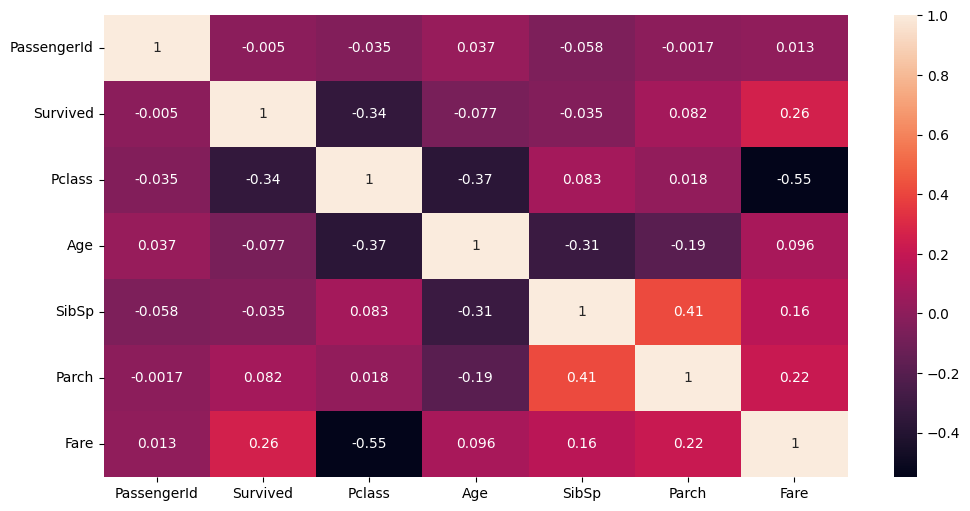

In [3]:
plt.figure(figsize=(12,6))
sns.heatmap(data=titanic_dataset.corr(), annot=True)

In [4]:
titanic_dataset.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

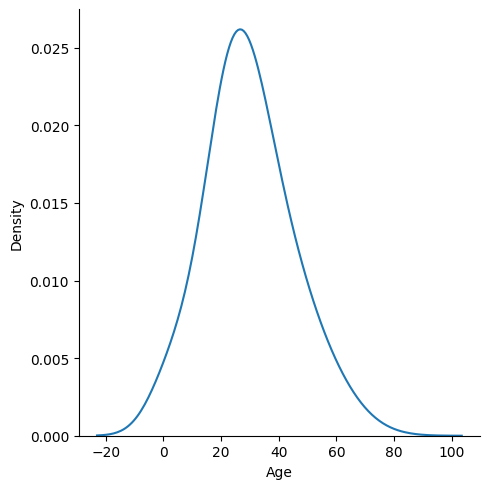

In [5]:
sns.displot(titanic_dataset, x="Age", kind="kde", bw_adjust=2)

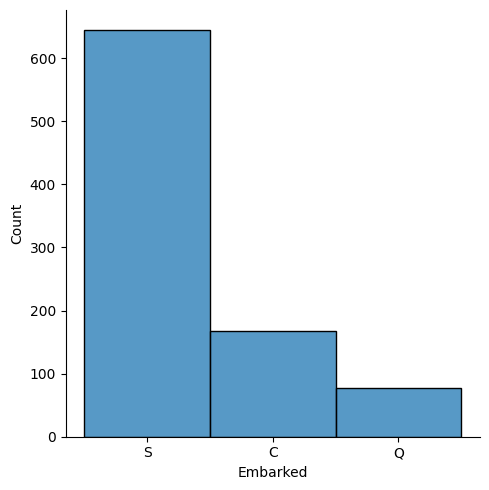

In [6]:
sns.displot(titanic_dataset, x="Embarked", discrete=True)

In [7]:
titanic_dataset.Embarked.fillna('S', inplace=True)

#### Preprocessing Pipeline
1) Drop Features : Name, Ticket & Cabin
2) Impute Age 
3) Turn Sex into Binary/Numeric
4) One Hot Encoder 'Embarked'

In [8]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

class FeaturesDropper(BaseEstimator, TransformerMixin):
    
    def fit(self, X,y=None):
        return self
    
    def transform(self, X):
        return X.drop(['Name','Ticket','Cabin'], axis =1)

class AgeImputer(BaseEstimator, TransformerMixin):
    
    def fit(self, X,y=None):
        return self
    
    def transform(self, X):
        imputer = SimpleImputer(strategy='mean')
        X['Age'] = imputer.fit_transform(X[['Age']])
        return X

class FeatureEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X,y=None):
        return self
    
    def transform(self, X):
        sex_dict = {'male':0, 'female':1}
        X['Sex'] = [sex_dict[g] for g in X['Sex']]
        
        #OneHotEncode Embarked
        encoder = OneHotEncoder()
        matrix = encoder.fit_transform(X[['Embarked']]).toarray()
        column_names = ['C','S','Q']
        
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]
            
        return X.drop(['Embarked'], axis=1)


In [9]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([
    ('dropper', FeaturesDropper()),
    ('imputer', AgeImputer()),
    ('endcoder', FeatureEncoder())    
])

In [10]:
df = titanic_dataset
df_modified = pipe.fit_transform(df)

In [11]:
df_modified.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,C,S,Q
0,1,0,3,0,22.0,1,0,7.2500,0.0,0.0,1.0
1,2,1,1,1,38.0,1,0,71.2833,1.0,0.0,0.0
2,3,1,3,1,26.0,0,0,7.9250,0.0,0.0,1.0
3,4,1,1,1,35.0,1,0,53.1000,0.0,0.0,1.0
4,5,0,3,0,35.0,0,0,8.0500,0.0,0.0,1.0


In [12]:
from sklearn.model_selection import train_test_split
X = df_modified.drop(columns='Survived', axis=1)
y = df_modified.Survived
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33,random_state=0)

#### Data Standardization

In [13]:
from sklearn.preprocessing import StandardScaler
scaler =  StandardScaler()
scaler.fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_train_transformed.std()

1.0

In [14]:
X_test_standardized = scaler.transform(X_test)
X_test_standardized.std()

0.9912443976939693

#### Training Model , Accuracy Score

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
clf = LogisticRegression().fit(X_train_transformed, y_train)

In [16]:
x_train_pred = clf.predict(X_train_transformed)
x_train_pred
training_data_acc_score=accuracy_score(x_train_pred, y_train)
print(f"Accuracy score of the trainig data: {training_data_acc_score} ")


Accuracy score of the trainig data: 0.8087248322147651 


In [17]:
# Acc score for the test set
x_test_pred = clf.predict(X_test_standardized)
test_data_acc_score = accuracy_score(x_test_pred, y_test)
print(f"Accuracy score of the trainig data: {test_data_acc_score} ")

Accuracy score of the trainig data: 0.7898305084745763 


#### Confusion Matrix of Testing Data

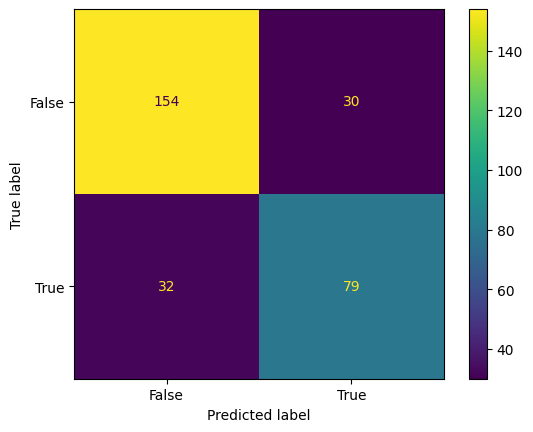

In [18]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, x_test_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_test, x_test_pred))


              precision    recall  f1-score   support

           0       0.83      0.84      0.83       184
           1       0.72      0.71      0.72       111

    accuracy                           0.79       295
   macro avg       0.78      0.77      0.78       295
weighted avg       0.79      0.79      0.79       295



#### Predication of test.csv

In [20]:
final_test = pd.read_csv('./test.csv')
final_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [21]:
df_t = final_test
test_data = pipe.fit_transform(df_t)

In [22]:
test_data.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,C,S,Q
0,892,3,0,34.5,0,0,7.8292,0.0,1.0,0.0
1,893,3,1,47.0,1,0,7.0000,0.0,0.0,1.0
2,894,2,0,62.0,0,0,9.6875,0.0,1.0,0.0
3,895,3,0,27.0,0,0,8.6625,0.0,0.0,1.0
4,896,3,1,22.0,1,1,12.2875,0.0,0.0,1.0


In [23]:
test_data['Fare'].fillna(test_data.Fare.mean(), inplace=True)
test_data.isnull().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
C              0
S              0
Q              0
dtype: int64

In [24]:
test_data_std = scaler.fit_transform(test_data)
test_data_std.std()

1.0

In [25]:
prediction_test = clf.predict(test_data_std)
prediction_test

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [26]:
final_test_df = pd.DataFrame(final_test['PassengerId'])
final_test_df['Survived'] = prediction_test
final_test_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [28]:
final_test_df.to_csv('test_predicted.csv', index=False)